In [1]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report


In [2]:
dir = '../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'
label = []
path = []
for dirname, _,filenames in os.walk(dir):
    for filename in filenames:
        if os.path.splitext(filename)[1]=='.png':
            if dirname.split()[-1]!='GT':          
                label.append(os.path.split(dirname)[1])
                path.append(os.path.join(dirname,filename))

df = pd.DataFrame(columns=['path','label'])
df['path']=path
df['label']=label

### Veri Setinden Örnekler

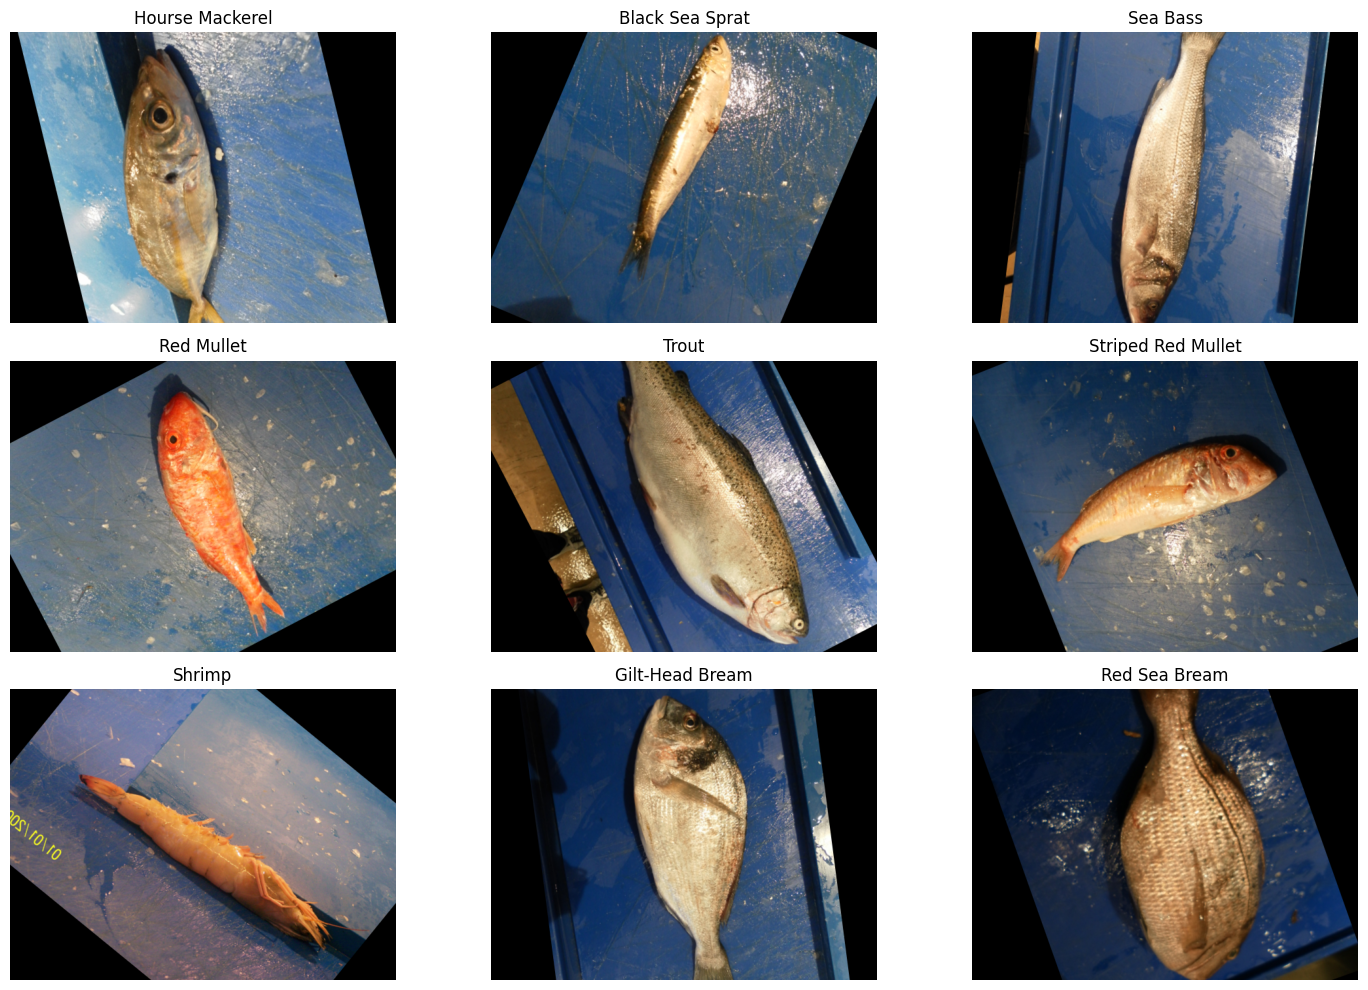

In [3]:
unique_labels = df['label'].unique()

# Her sınıftan bir örnek görüntü gösterelim
plt.figure(figsize=(15, 10))

for i, label in enumerate(unique_labels[:9]):  # İlk 9 sınıfı alalım
    # Bu sınıfa ait rastgele bir görüntü seçelim
    sample = df[df['label'] == label].sample(1).iloc[0]
    img_path = sample['path']
    
    # Görüntüyü yükleyelim
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Renk uzayını düzeltelim (BGR -> RGB)

    # Görüntüyü gösterelim
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [4]:
print(f" Satır Sayısı : {df.shape[0]} \n Sütun Sayısı : {df.shape[1]} ")


 Satır Sayısı : 9000 
 Sütun Sayısı : 2 


In [5]:
df['label'].value_counts(ascending=True)

label
Hourse Mackerel       1000
Black Sea Sprat       1000
Sea Bass              1000
Red Mullet            1000
Trout                 1000
Striped Red Mullet    1000
Shrimp                1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Name: count, dtype: int64

### Eğitim, Doğrulama ve Test Setlerine Ayırma:


In [6]:
# Önce eğitim ve geçerli test setini ayırıyoruz (80% eğitim, 20% test ve validation)
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Sonra geçici test setini doğrulama ve test seti olarak ikiye ayırıyoruz (10% doğrulama, 10% test)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

# Sonuçların boyutlarını kontrol edelim
print(f"Eğitim seti boyutu: {len(train_df)}")
print(f"Doğrulama seti boyutu: {len(val_df)}")
print(f"Test seti boyutu: {len(test_df)}")


Eğitim seti boyutu: 7200
Doğrulama seti boyutu: 900
Test seti boyutu: 900


In [7]:
# Görselleri ve etiketleri yükleme fonksiyonu
def load_images(df, img_size=(128, 128)):
    images = []
    labels = []
    
    for i, row in df.iterrows():
        img = cv2.imread(row['path'])
        img = cv2.resize(img, img_size)  # Görüntüleri yeniden boyutlandırıyoruz
        img = img / 255.0  # Normalizasyon (0-1 aralığına)
        images.append(img)
        labels.append(row['label'])
    
    images = np.array(images)
    labels = pd.Categorical(df['label']).codes  # Kategorik etiketleri numerik koda çeviriyoruz
    labels = to_categorical(labels)  # One-hot encoding (sınıfları bir vektör haline getirme)
    
    return images, labels

# Eğitim, doğrulama ve test verilerini yükleyelim
train_images, train_labels = load_images(train_df)
val_images, val_labels = load_images(val_df)
test_images, test_labels = load_images(test_df)

# Veri setlerinin boyutlarını kontrol edelim
print(f"Train images shape: {train_images.shape}")
print(f"Validation images shape: {val_images.shape}")
print(f"Test images shape: {test_images.shape}")


Train images shape: (7200, 128, 128, 3)
Validation images shape: (900, 128, 128, 3)
Test images shape: (900, 128, 128, 3)


In [17]:
import tensorflow as tf
from tensorflow.keras import backend as K

# TensorFlow oturumunu sıfırlama
K.clear_session()


# Kendi Oluşturduğum Model üzerinden eğitim

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization

# Modeli oluşturalım
model = Sequential()
model.add(Flatten(input_shape=(128, 128, 3)))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(9, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,583,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,690,825 (48.41 MB)

 Trainable params: 12,690,825 (48.41 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

# Erken durdurma uygulamak
early_stopping = EarlyStopping(monitor='val_loss', patience=9, restore_best_weights=True)

history = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    epochs=100,
                    batch_size=32,
                    callbacks=[early_stopping])


Epoch 1/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.1139 - loss: 3.1241 - val_accuracy: 0.2011 - val_loss: 2.0785
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1513 - loss: 2.1497 - val_accuracy: 0.2400 - val_loss: 1.9789
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1976 - loss: 2.0017 - val_accuracy: 0.3678 - val_loss: 1.8321
Epoch 4/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2712 - loss: 1.8562 - val_accuracy: 0.3811 - val_loss: 1.6850
Epoch 5/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3106 - loss: 1.7451 - val_accuracy: 0.3867 - val_loss: 1.5935
Epoch 6/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3488 - loss: 1.6157 - val_accuracy: 0.3800 - val_loss: 1.6382
Epoch 7/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3826 - loss: 1.5814 - val_accuracy: 0.4244 - val_loss: 1.5138
Epoch 8/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4127 - loss: 1.5034 - val_acc

## Test Verisi için Accuracy ve Loss Değerleri

In [20]:
# Test seti üzerinde performansı kontrol edelim
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9029 - loss: 0.3114
Test Loss: 0.32174938917160034
Test Accuracy: 0.8966666460037231


### Accuracy Loss Grafikleri

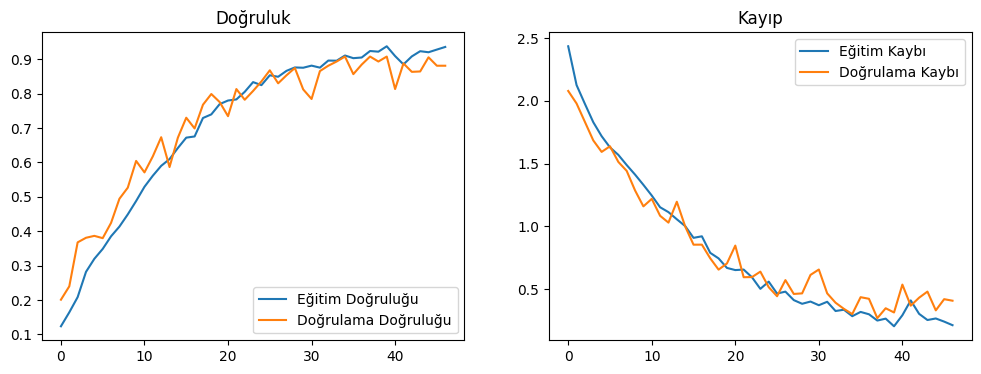

In [22]:
def metrikleri_gorsellestir(history):
    
    # Eğitim sürecini görselleştirelim
    plt.figure(figsize=(12, 4))

    # Doğruluk
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
    plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
    plt.title('Doğruluk')
    plt.legend()

    # Kayıp
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Eğitim Kaybı')
    plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
    plt.title('Kayıp')
    plt.legend()

    plt.show()
    
metrikleri_gorsellestir(history)


Yukarıda görüldüğü gibi eğitim doğruluğu ve doğruluğu overfitting'e sebep olmadan callback ile eğitimi 47 epochda durdurdu. 

In [23]:
def confusion_matrix_gorsellestir(conf_matrix,y_true,y_pred_classes):
    # Karışıklık matrisini görselleştirme
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=df['label'].unique(), yticklabels=df['label'].unique())
    plt.xlabel('Tahmin Edilen')
    plt.ylabel('Gerçek')
    plt.title('Karışıklık Matrisi')
    plt.show()
    # Classification report oluşturma ve yazdırma
    print("Sınıflandırma Raporu:\n")
    print(classification_report(y_true, y_pred_classes, target_names=df['label'].unique()))

### Confusion Matrix Grafiği ve Classification Report

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


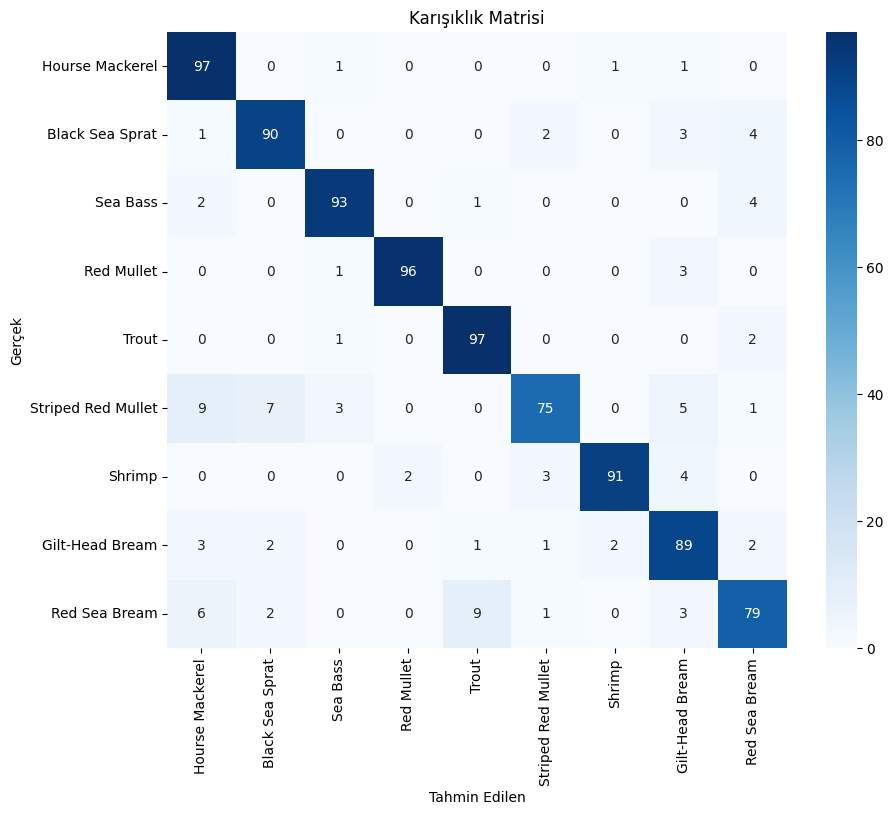

Sınıflandırma Raporu:

                    precision    recall  f1-score   support

   Hourse Mackerel       0.82      0.97      0.89       100
   Black Sea Sprat       0.89      0.90      0.90       100
          Sea Bass       0.94      0.93      0.93       100
        Red Mullet       0.98      0.96      0.97       100
             Trout       0.90      0.97      0.93       100
Striped Red Mullet       0.91      0.75      0.82       100
            Shrimp       0.97      0.91      0.94       100
   Gilt-Head Bream       0.82      0.89      0.86       100
     Red Sea Bream       0.86      0.79      0.82       100

          accuracy                           0.90       900
         macro avg       0.90      0.90      0.90       900
      weighted avg       0.90      0.90      0.90       900



In [24]:
# Test seti üzerinde tahminler yapalım
y_pred = model.predict(test_images)

# Tahmin edilen sınıfları alalım (en yüksek olasılığa sahip sınıf)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels, axis=1)  # Gerçek etiketler

# Karışıklık matrisi oluşturma
conf_matrix = confusion_matrix(y_true, y_pred_classes)

confusion_matrix_gorsellestir(conf_matrix,y_true,y_pred_classes)


Buradaki değerlerden de test veri seti için accuracy değeri 0.90 yani yüzde 90 doğrulukla çalışmaktadır.
"Striped Red Mullet" sınıfı için precision 0.91 olsa da recall 0.75, yani model bu sınıfta pozitif tahminlerde iyi ancak gerçek örneklerin sadece %75'ini doğru tespit edebilmiş.
"Shrimp" ve "Red Mullet" gibi sınıflar oldukça yüksek doğruluk oranlarına sahipken, "Gilt-Head Bream" ve "Red Sea Bream" gibi sınıflar nispeten daha düşük değerlere sahip.
Macro avg (makro ortalama), her sınıfın eşit şekilde ele alınarak hesaplanan ortalama değerleri gösterir. Burada tüm sınıfların ortalama doğruluk, duyarlılık ve F1-score'u %90 civarında.
Weighted avg (ağırlıklı ortalama), her sınıfın örnek sayısına göre ağırlıklandırılarak hesaplanan değerleri gösterir. Bu da %90 olarak çıkmış, bu da modelin performansının genel olarak iyi olduğunu doğruluyor.
Sonuç olarak, modelin performansı genel anlamda yüksek olsa da bazı sınıflarda (örneğin "Striped Red Mullet" ve "Red Sea Bream") iyileştirme fırsatları olabilir.

# Hiperparametre Optimizasyonu

In [9]:
import tensorflow as tf
from tensorflow import keras
from keras_tuner import Hyperband
import numpy as np

def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(128, 128, 3)))
    
    # Optimize number of dense layers and their units
    for i in range(hp.Int('num_dense_layers', min_value=2, max_value=5)):
        model.add(keras.layers.Dense(
            units=hp.Int(f'dense_{i}_units', 
                        min_value=64, 
                        max_value=512, 
                        step=64),
            activation=hp.Choice(f'dense_{i}_activation', 
                               values=['relu', 'elu', 'selu'])
        ))
        
        # Add optional batch normalization
        if hp.Boolean(f'batch_norm_{i}'):
            model.add(keras.layers.BatchNormalization())
            
        # Optimize dropout rate
        model.add(keras.layers.Dropout(
            hp.Float(f'dropout_{i}', 
                    min_value=0.1, 
                    max_value=0.5, 
                    step=0.1)
        ))
    
    # Output layer
    model.add(keras.layers.Dense(9, activation='softmax'))
    
    # Optimize learning rate
    learning_rate = hp.Float('learning_rate', 
                           min_value=1e-4, 
                           max_value=1e-2, 
                           sampling='log')
    
    # Optimize optimizer
    optimizer_choice = hp.Choice('optimizer', 
                               values=['adam', 'rmsprop', 'sgd'])
    
    if optimizer_choice == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Hyperband optimizer
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='hyperparameter_tuning',
    project_name='fish_classification'
)

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

# Search for best hyperparameters
tuner.search(
    train_images,
    train_labels,
    validation_data=(val_images, val_labels),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

# Get best hyperparameters and model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)





Trial 90 Complete [00h 00m 59s]
val_accuracy: 0.9433333277702332

Best val_accuracy So Far: 0.9811111092567444
Total elapsed time: 00h 38m 53s


## En iyi modelin eğitimi

In [10]:
# Train best model
besthistory = best_model.fit(
    train_images,
    train_labels,
    validation_data=(val_images, val_labels),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.4664 - loss: 1.6505 - val_accuracy: 0.4300 - val_loss: 2.2035 - learning_rate: 3.3760e-04
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7632 - loss: 0.6934 - val_accuracy: 0.3956 - val_loss: 2.5262 - learning_rate: 3.3760e-04
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8499 - loss: 0.4320 - val_accuracy: 0.6989 - val_loss: 0.9462 - learning_rate: 3.3760e-04
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8961 - loss: 0.3049 - val_accuracy: 0.7444 - val_loss: 0.7772 - learning_rate: 3.3760e-04
Epoch 5/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9220 - loss: 0.2187 - val_accuracy: 0.8311 - val_loss: 0.5584 - learning_rate: 3.3760e-04
Epoch 6/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9379 - loss: 0.1856 - val_accuracy: 0.8133 - val_loss: 0.6105 - learning_rate: 3.3760e-04
Epoch 7/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy:

### Modelin test accuracy değeri ve modelin hiperparametreleri

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9746 - loss: 0.0715

Best model test accuracy: 0.9733

Best Hyperparameters:
num_dense_layers: 3
dense_0_units: 384
dense_0_activation: selu
batch_norm_0: True
dropout_0: 0.1
dense_1_units: 192
dense_1_activation: relu
batch_norm_1: True
dropout_1: 0.1
learning_rate: 0.00033760108458835025
optimizer: rmsprop
dense_2_units: 256
dense_2_activation: elu
batch_norm_2: True
dropout_2: 0.30000000000000004
dense_3_units: 384
dense_3_activation: elu
batch_norm_3: True
dropout_3: 0.4
dense_4_units: 192
dense_4_activation: elu
batch_norm_4: False
dropout_4: 0.30000000000000004
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0080


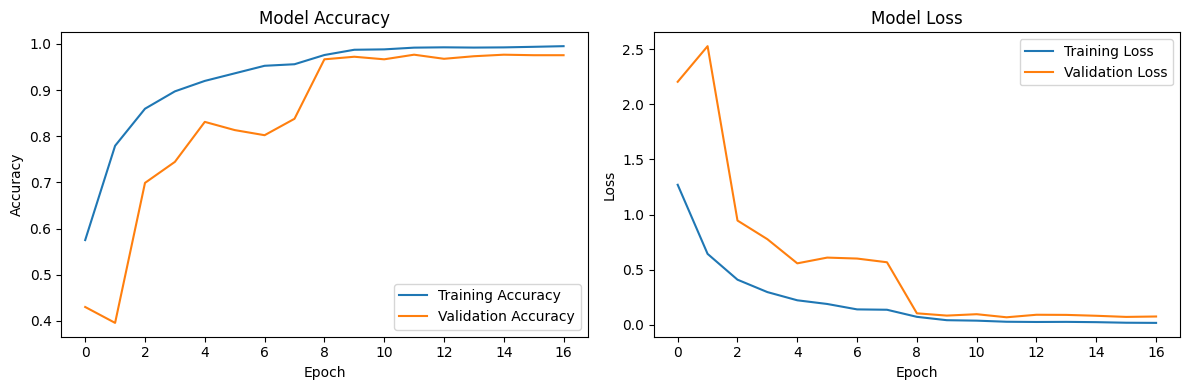

In [11]:
# Evaluate best model
test_loss, test_acc = best_model.evaluate(test_images, test_labels)
print(f"\nBest model test accuracy: {test_acc:.4f}")

# Print best hyperparameters
print("\nBest Hyperparameters:")
for param, value in best_hps.values.items():
    print(f"{param}: {value}")

metrikleri_gorsellestir(besthistory)  

### Confusion Matrix Grafiği ve Classification Report

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


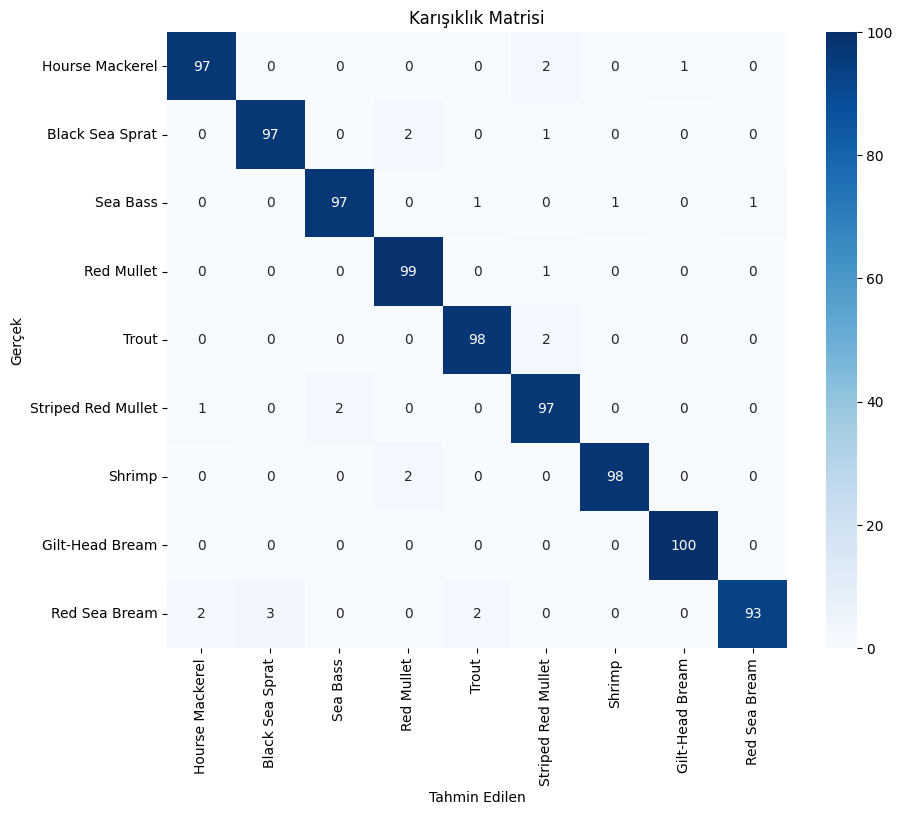

Sınıflandırma Raporu:

                    precision    recall  f1-score   support

   Hourse Mackerel       0.97      0.97      0.97       100
   Black Sea Sprat       0.97      0.97      0.97       100
          Sea Bass       0.98      0.97      0.97       100
        Red Mullet       0.96      0.99      0.98       100
             Trout       0.97      0.98      0.98       100
Striped Red Mullet       0.94      0.97      0.96       100
            Shrimp       0.99      0.98      0.98       100
   Gilt-Head Bream       0.99      1.00      1.00       100
     Red Sea Bream       0.99      0.93      0.96       100

          accuracy                           0.97       900
         macro avg       0.97      0.97      0.97       900
      weighted avg       0.97      0.97      0.97       900



In [13]:
# Test seti üzerinde tahminler yapalım
y_pred = best_model.predict(test_images)

# Tahmin edilen sınıfları alalım (en yüksek olasılığa sahip sınıf)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels, axis=1)  # Gerçek etiketler

# Karışıklık matrisi oluşturma
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Karışıklık matrisini görselleştirme
confusion_matrix_gorsellestir(conf_matrix,y_true,y_pred_classes)


Hiperparametre optimizasyonu sonrasında modelin performansı oldukça iyileşmiş görünüyor.
Recall değerlerinde de önemli bir artış var. Örneğin, önceki raporda düşük kalan "Striped Red Mullet" sınıfı için recall %75'ten %97'ye yükselmiş. Bu, modelin bu sınıfa ait örnekleri daha iyi tespit edebildiğini gösteriyor.
"Red Sea Bream" sınıfı dışındaki tüm sınıflarda %97 veya daha yüksek recall oranlarına ulaşılmış.
Hiperparametre optimizasyonu modelin doğruluk oranını %90’dan %97’ye çıkararak önemli bir iyileştirme sağlamış.
Hiperparametre optimizasyonu, modelin performansını önemli ölçüde artırmış ve özellikle zorlayıcı sınıflarda (örneğin "Striped Red Mullet" ve "Red Sea Bream") belirgin iyileştirmeler sağlamış.